<a href="https://colab.research.google.com/github/YashJain0224/VISION-SCOPE-PREDICT-OCULAR-DISEASES-USING-MACHINE-LEARNING/blob/main/Vision_Scope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Libraries


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications import InceptionResNetV2, EfficientNetB0, ResNet50

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [ ]:
import kagglehub
import tensorflow as tf
import os

# Download the dataset
dataset_path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")

# Print the actual downloaded dataset path
print("Dataset downloaded to:", dataset_path)

# Check folder structure
print("Contents of dataset folder:", os.listdir(dataset_path))

# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

# Correct dataset path
correct_path = os.path.join(dataset_path, "dataset")  # Use the right folder

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    correct_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Get class names
class_names = dataset.class_names
print("Class Names:", class_names)
print("Number of batches:", len(dataset))


100%|██████████| 736M/736M [00:06<00:00, 112MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/gunavenkatdoddi/eye-diseases-classification/versions/1
Contents of dataset folder: ['dataset']
Found 4217 files belonging to 4 classes.
Class Names: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']
Number of batches: 132


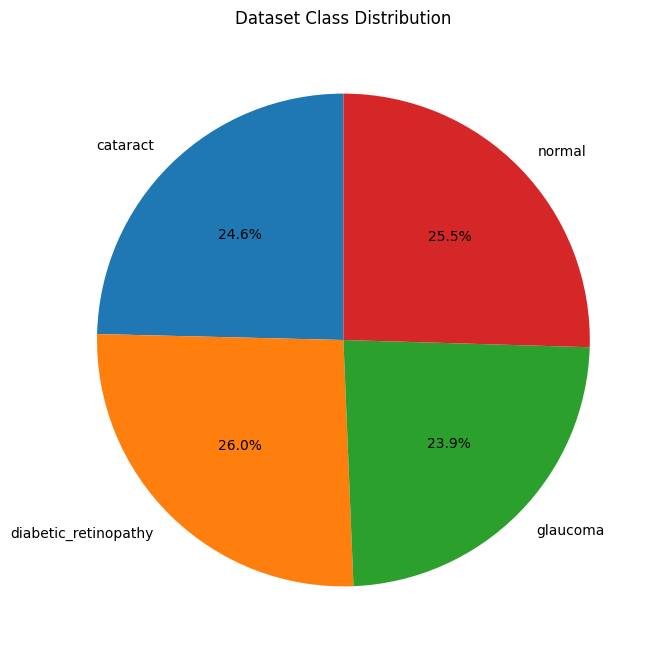

In [ ]:
count_per_class = {class_name: 0 for class_name in class_names}
for _, labels in dataset:
    for label in labels.numpy():
        count_per_class[class_names[label]] += 1

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(count_per_class.values(), labels=count_per_class.keys(), autopct='%1.1f%%', startangle=90)
plt.title("Dataset Class Distribution")
plt.show()


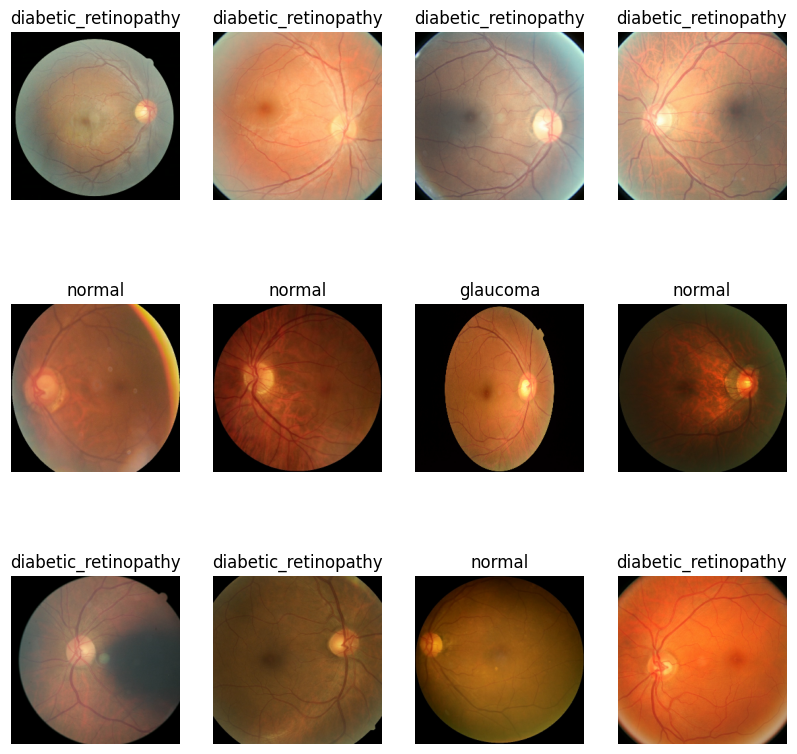

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # Compute the total number of elements (images) in the dataset
    ds_size = sum(1 for _ in ds)  # This ensures we count total samples

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    # Calculate dataset sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Assign partitions correctly
    train_ds = ds.skip(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

27

In [ ]:
len(val_ds)

13

In [ ]:
len(test_ds)

14

In [ ]:
trains_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import tensorflow as tf

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),  # Changed to tf.keras.layers.Resizing
    tf.keras.layers.Rescaling(1.0/255) # Changed to tf.keras.layers.Rescaling
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Use layers.RandomFlip directly
    layers.RandomRotation(0.2)  # Use layers.RandomRotation directly
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax'),

])
model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 4)                     │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,812 (718.02 KB)

 Trainable params: 183,812 (718.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)



Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 170s 5s/step - accuracy: 0.2680 - loss: 1.3854 - val_accuracy: 0.4014 - val_loss: 1.2965
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 5s/step - accuracy: 0.3988 - loss: 1.2920 - val_accuracy: 0.4784 - val_loss: 1.1861
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 191s 4s/step - accuracy: 0.4104 - loss: 1.2376 - val_accuracy: 0.4712 - val_loss: 1.1160
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 149s 5s/step - accuracy: 0.5113 - loss: 1.1139 - val_accuracy: 0.5024 - val_loss: 1.1213
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 201s 5s/step - accuracy: 0.4924 - loss: 1.0660 - val_accuracy: 0.5721 - val_loss: 0.9864
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 137s 4s/step - accuracy: 0.6041 - loss: 0.9357 - val_accuracy: 0.5072 - val_loss: 0.9828
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.5390 - loss: 1.0061 - val_accuracy: 0.6490 - val_loss: 0.8823
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 156s 5s/step - accuracy: 0.6342 - loss: 0.9118 - val_accuracy: 0.6082 - v

In [ ]:
scores = model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7791 - loss: 0.4717


In [ ]:
scores

[0.4637673497200012, 0.7924107313156128]

In [ ]:
history

In [ ]:
history.params

{'verbose': 1, 'epochs': 25, 'steps': 27}

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [ ]:
history.history['accuracy']

[0.2777777910232544,
 0.4131944477558136,
 0.43518519401550293,
 0.5023148059844971,
 0.5122520327568054,
 0.5648148059844971,
 0.5787037014961243,
 0.6400462985038757,
 0.6400462985038757,
 0.6863425970077515,
 0.7048611044883728,
 0.7141203880310059,
 0.7245370149612427,
 0.7175925970077515,
 0.7546296119689941,
 0.7569444179534912,
 0.7361111044883728,
 0.7245370149612427,
 0.7326388955116272,
 0.7432905435562134,
 0.7572928667068481,
 0.7650462985038757,
 0.7824074029922485,
 0.7673611044883728,
 0.7841306924819946]

In [ ]:
custom_cnn_history = history

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

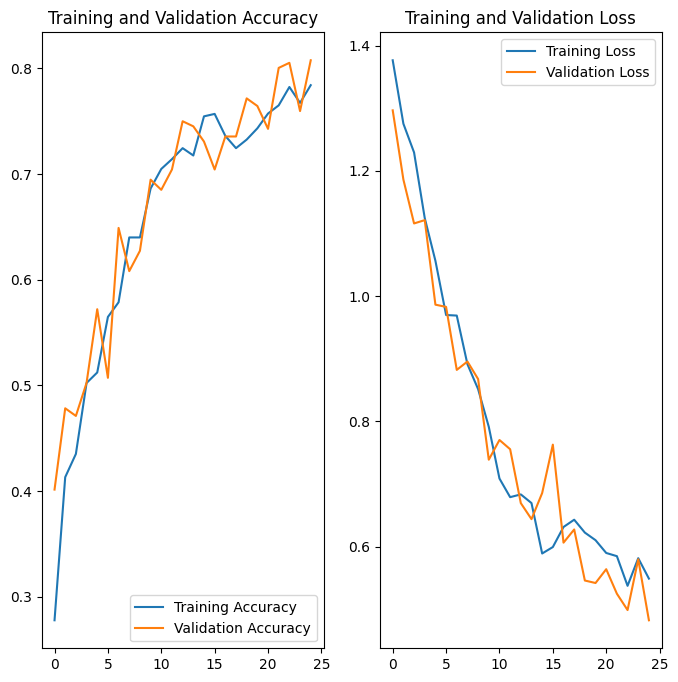

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def create_model(base_model, n_classes):
    base_model.trainable = False  # Freeze base model layers
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

In [ ]:
base_models = {
    "InceptionResNetV2": InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
}

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
trained_models = {}  # Make sure this exists before the loop
results = {}

for name, base_model in base_models.items():
    print(f"\nTraining {name} model...")
    model = create_model(base_model, n_classes)
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    history = model.fit(
        train_ds,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=val_ds,
        verbose=1
    )

    results[name] = history
    trained_models[name] = model  # ✅ Store using the same `name` key



Training InceptionResNetV2 model...
Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 460s 16s/step - accuracy: 0.2439 - loss: 61.7221 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 428s 15s/step - accuracy: 0.2461 - loss: 1.3866 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 440s 15s/step - accuracy: 0.2421 - loss: 1.3864 - val_accuracy: 0.2500 - val_loss: 1.3862
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 438s 16s/step - accuracy: 0.2738 - loss: 1.3861 - val_accuracy: 0.2500 - val_loss: 1.3861
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 424s 15s/step - accuracy: 0.2631 - loss: 1.3862 - val_accuracy: 0.2500 - val_loss: 1.3861
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 427s 15s/step - accuracy: 0.2255 - loss: 1.3863 - val_accuracy: 0.2500 - val_loss: 1.3859
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 432s 16s/step - accuracy: 0.2618 - loss: 1.3859 - val_accuracy: 0.2500 - val_loss: 1.3859
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 433s 15s/step - accuracy: 0.

In [ ]:
best_model = None
best_model_name = ""
best_accuracy = 0.0

for name, model in trained_models.items():
    print(f"Evaluating {name} model on test data...")
    loss, accuracy = model.evaluate(test_ds, verbose=0)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

Evaluating InceptionResNetV2 model on test data...
Evaluating EfficientNetB0 model on test data...
Evaluating ResNet50 model on test data...


In [ ]:
# Determine best model based on highest final validation accuracy
best_model_name = max(results, key=lambda name: results[name].history['val_accuracy'][-1])
best_model = trained_models.get(best_model_name, model)  # fallback to last trained model

print(f"Best model based on validation accuracy: {best_model_name}")

Best model based on validation accuracy: EfficientNetB0



✅ Best model: EfficientNetB0 with accuracy: 0.9442
First image to predict:


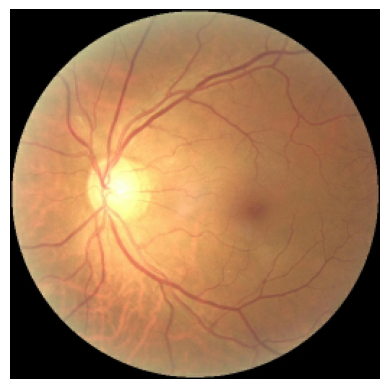

Actual label: normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted label: normal


In [ ]:
print(f"\n✅ Best model: {best_model_name} with accuracy: {best_accuracy:.4f}")

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict:")
    plt.imshow(first_image)
    plt.axis('off')
    plt.show()

    print("Actual label:", class_names[first_label])

    batch_prediction = best_model.predict(images_batch)
    predicted_label = class_names[np.argmax(batch_prediction[0])]
    print("Predicted label:", predicted_label)

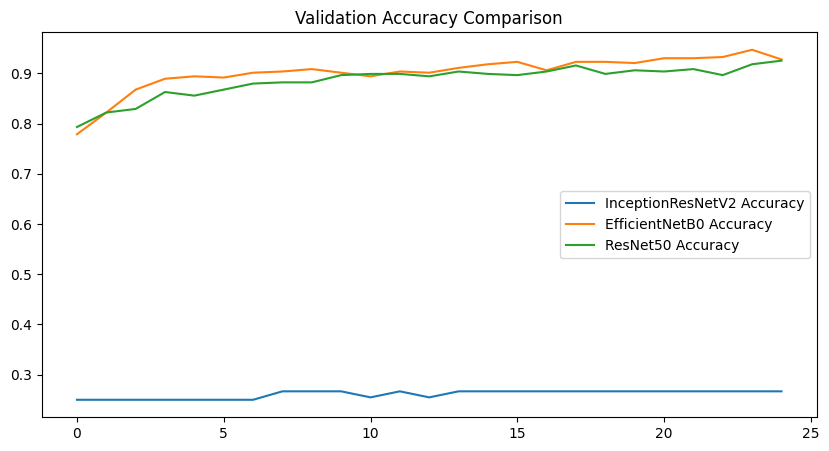

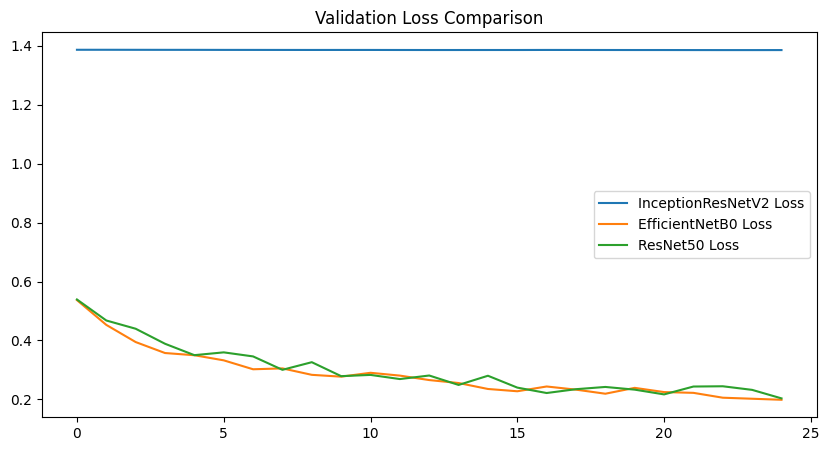

In [ ]:
plt.figure(figsize=(10, 5))
for name, history in results.items():
    plt.plot(history.history['val_accuracy'], label=f'{name} Accuracy')
plt.legend()
plt.title('Validation Accuracy Comparison')
plt.show()

plt.figure(figsize=(10, 5))
for name, history in results.items():
    plt.plot(history.history['val_loss'], label=f'{name} Loss')
plt.legend()
plt.title('Validation Loss Comparison')
plt.show()

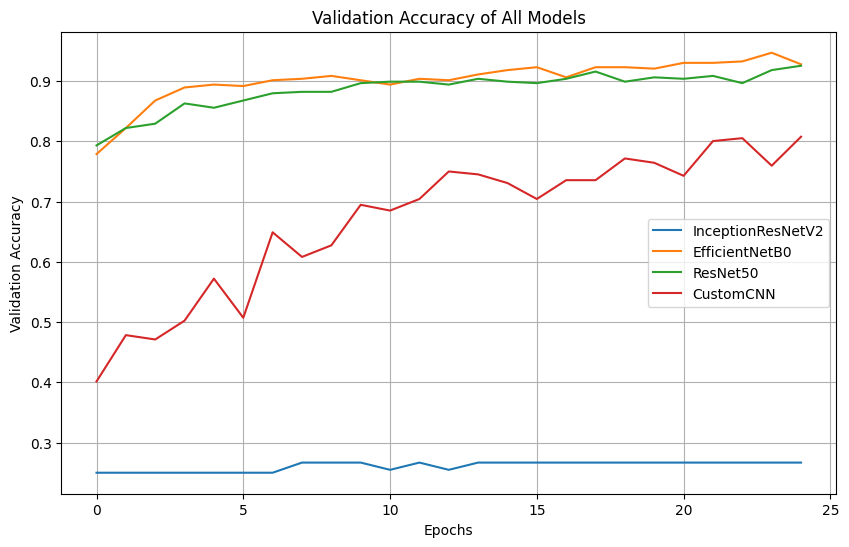

In [ ]:
# Include custom CNN in results for plotting
results["CustomCNN"] = custom_cnn_history

plt.figure(figsize=(10, 6))
for name, history in results.items():
    val_acc = history.history['val_accuracy']
    plt.plot(range(EPOCHS), val_acc, label=name)

plt.title("Validation Accuracy of All Models")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


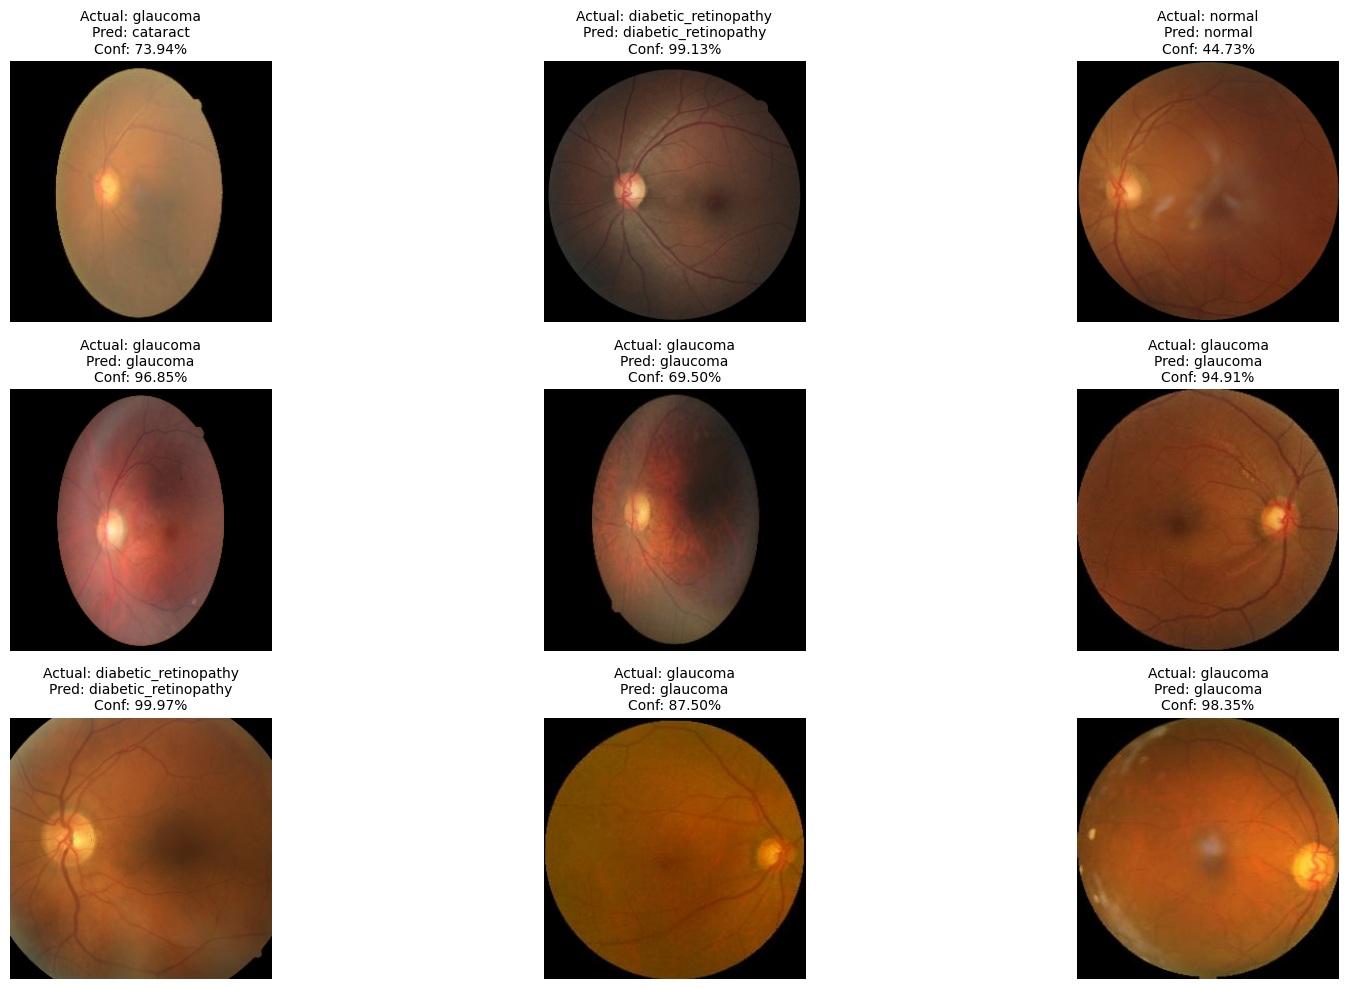

In [ ]:
import matplotlib.pyplot as plt

# Take one batch of images from test dataset
for images, labels in test_ds.take(1):
    plt.figure(figsize=(18, 10))
    for i in range(9):  # Show 9 predictions
        ax = plt.subplot(3, 3, i + 1)
        sample_image = images[i]
        actual_label = labels[i].numpy()

        # Predict
        img_array = tf.expand_dims(sample_image, 0)  # Add batch dimension
        predictions = best_model.predict(img_array)
        predicted_class = np.argmax(predictions[0])
        confidence = np.max(predictions[0]) * 100

        # Plot image with actual vs predicted
        plt.imshow(sample_image.numpy().astype("uint8"))
        plt.title(
            f"Actual: {class_names[actual_label]}\nPred: {class_names[predicted_class]}\nConf: {confidence:.2f}%",
            fontsize=10
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


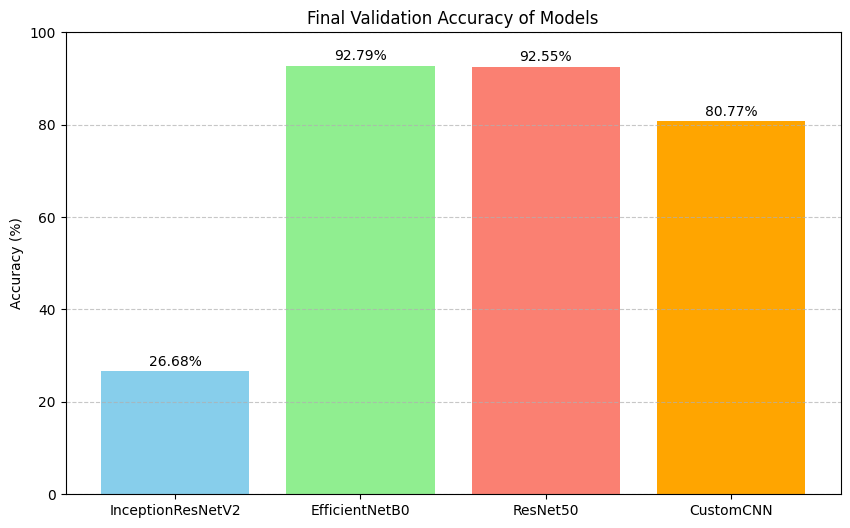

In [ ]:
import matplotlib.pyplot as plt

# Collect final validation accuracies
final_val_accuracies = {
    name: history.history['val_accuracy'][-1] * 100  # convert to percentage
    for name, history in results.items()
}

# Prepare data for bar plot
model_names = list(final_val_accuracies.keys())
accuracies = list(final_val_accuracies.values())

# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon', 'orange'])

# Add accuracy values on top of each bar
for bar, acc in zip(bars, accuracies):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

# Chart settings
plt.title('Final Validation Accuracy of Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


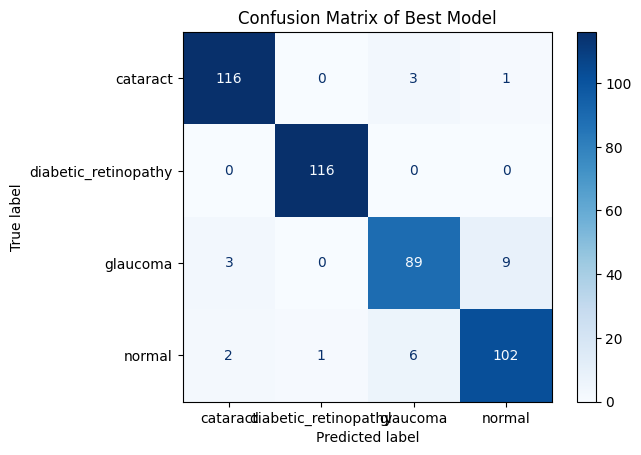

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get predictions on test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix of Best Model")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))


                      precision    recall  f1-score   support

            cataract       0.96      0.97      0.96       120
diabetic_retinopathy       0.99      1.00      1.00       116
            glaucoma       0.91      0.88      0.89       101
              normal       0.91      0.92      0.91       111

            accuracy                           0.94       448
           macro avg       0.94      0.94      0.94       448
        weighted avg       0.94      0.94      0.94       448

